In [1]:
import time
import yaml
import tensorflow as tf
import tensorflow_gnn as tfgnn
from pathlib import Path
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import Image
print(f'Using TensorFlow v{tf.__version__} and TensorFlow-GNN v{tfgnn.__version__}')

from graph2tac.loader.data_server import DataServer
from graph2tac.tfgnn.dataset import DataServerDataset, TFRecordDataset, BIDIRECTIONAL, UNDIRECTED
from graph2tac.tfgnn.tasks import PredictionTask, TacticPrediction, LocalArgumentPrediction, GlobalArgumentPrediction, DefinitionTask, arguments_filter
from graph2tac.tfgnn.models import SIMPLE_CONVOLUTION_GNN, GCN_CONVOLUTION_GNN, ATTENTION_GNN, DENSE_TACTIC, SIMPLE_RNN, DENSE_DEFINITION
from graph2tac.tfgnn.metrics import SparseCategoricalConfusionMatrix, FullLocalArgumentSparseCategoricalAccuracy
from graph2tac.tfgnn.train import Trainer
from graph2tac.tfgnn.predict import TFGNNPredict

Using TensorFlow v2.9.1 and TensorFlow-GNN v0.2.1


Check that TF is using the GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# <a id="contents">Contents</a>

- [Contents](#contents)
- [Data loading](#data_loading)
    - [Data inspection](#data_loading_data_inspection)
        - [Proof-states](#data_inspection_proofstates)
        - [Definitions](#data_inspection_definitions)
    - [Data statistics](#data_statistics)
- [Prediction tasks](#prediction_tasks)
    - [The `TacticPrediction` task](#tactic_prediction)
        - [Task inspection](#tactic_prediction_task_inspection)
        - [Data preparation](#tactic_prediction_data_preparation)
        - [Training](#tactic_prediction_training)
        - [Checkpointing](#tactic_prediction_checkpointing)
        - [Evaluation](#tactic_prediction_evaluation)
    - [The `LocalArgumentPrediction` task](#local_argument_prediction)
        - [Task inspection](#local_argument_prediction_task_inspection)
        - [Data preparation](#local_argument_prediction_data_preparation)
        - [Training](#local_argument_prediction_training)
        - [Checkpointing](#local_argument_prediction_checkpointing)
        - [Evaluation](#local_argument_prediction_evaluation)
    - [The `GlobalArgumentPrediction` task](#global_argument_prediction)
        - [Task inspection](#global_argument_prediction_task_inspection)
        - [Data preparation](#global_argument_prediction_data_preparation)
        - [Training](#global_argument_prediction_training)
        - [Checkpointing](#global_argument_prediction_checkpointing)
        - [Evaluation](#global_argument_prediction_evaluation)
- [The `Trainer` class](#trainer)
    - [Training](#trainer_training)
    - [Logs](#trainer_logs)
- [Definition tasks](#definition)
    - [Task inspection](#definition_inspection)
    - [Training](#definition_training)
- [The `Predict` class](#predict)
    - [Base tactic prediction](#predict_tactic)
    - [Local argument prediction](#predict_local_argument)
    - [Global argument prediction](#predict_global_argument)
    - [Batching predictions](#predict_batching)
    - [Evaluating predictions](#predict_evaluation)
- [Definition reconstruction](#definition_reconstruction)

# <a id="data_loading">Data loading</a> [↑](#contents)

Data can be loaded directly from the loader:

In [3]:
dataset = DataServerDataset(data_dir=Path('../tests/mini_stdlib/dataset'),
                            symmetrization=BIDIRECTIONAL,
                            add_self_edges=True,
                            max_subgraph_size=1024)

LOADING | indexing and top sorting bin files in ../tests/mini_stdlib/dataset...done.
LOADING | preparing data from 20 files.
LOADING | constructing file reference table...done.
LOADING | indexing all definitions...LOADING | definitions in spine: {len(global_nodes_in_spine)}
LOADING | definitions: 1002 
Indexed 1002 definitions in 0.105231 seconds.
LOADING | indexing all tactical action-outcomes in 20 files...LOADING | Indexed 2266 tactical action-outcomes in 0.010251 seconds.
LOADING | mmaping all capnp files and building data loader hash tables...done.
LOADING | data_online maps  20
20 buffer objects processed in 0.000193 seconds.
LOADING | in def_dependencies: max_subgraph_size=1024 bfs_option=True
LOADING | constructing shallow expansions of all definitions to build the graph of definition dependencies...done in 0.023604 seconds.
LOADING | NOTICE: the graph of definition dependencies should be precomputed and recorded to capnp bin files at the time of generation of the dataset. It i

C_LOADER INFO | processing 20 files
C_LOADER INFO | processing 20 files


Or, for best performance, it can also be loaded from TFRecord files:

In [4]:
dataset = TFRecordDataset(tfrecord_prefix=Path('../../data/mini_stdlib'),
                          symmetrization=BIDIRECTIONAL,
                          add_self_edges=True,
                          max_subgraph_size=1024)

graph2tac:INFO - counting proofstates (this can take a while)...


In either case, the arguments are:
- `symmetrization`: indicates whether edges are to be considered having the direction that is provided in the input graphs (`None`), both directions with the same edge class (`'undirected'`) or both directions with different edge classes (`'bidirectional'`)
- `add_self_edges`: indicates whether we should artificially add a self-edge to each node in the graph
- `max_subgraph_size`: bounds the number of nodes of the largest graph in the dataset.

For convenience, you can also use a YAML configuration file to specify these arguments:

In [5]:
dataset = DataServerDataset.from_yaml_config(data_dir=Path('../tests/mini_stdlib/dataset'),
                                             yaml_filepath=Path('../graph2tac/tfgnn/default_dataset_config.yml'))

LOADING | indexing and top sorting bin files in ../tests/mini_stdlib/dataset...done.
LOADING | preparing data from 20 files.
LOADING | constructing file reference table...done.
LOADING | indexing all definitions...LOADING | definitions in spine: {len(global_nodes_in_spine)}
LOADING | definitions: 1002 
Indexed 1002 definitions in 0.017884 seconds.
LOADING | indexing all tactical action-outcomes in 20 files...LOADING | Indexed 2266 tactical action-outcomes in 0.008771 seconds.
LOADING | mmaping all capnp files and building data loader hash tables...done.
LOADING | data_online maps  20
20 buffer objects processed in 0.000131 seconds.
LOADING | in def_dependencies: max_subgraph_size=1024 bfs_option=True
LOADING | constructing shallow expansions of all definitions to build the graph of definition dependencies...done in 0.022086 seconds.
LOADING | NOTICE: the graph of definition dependencies should be precomputed and recorded to capnp bin files at the time of generation of the dataset. It i

C_LOADER INFO | processing 20 files
C_LOADER INFO | processing 20 files


The `dataset` provides methods to generate `tf.data.Dataset` instances that stream `GraphTensor` objects, which encapsulate all the information we may need (_i.e._ both data _and_ labels). For proofstates, we have:

In [6]:
train_proofstates, valid_proofstates = dataset.proofstates(split=(9,1), split_random_seed=0)

As seen above, the following arguments are used to determine the train/validation split of the available data:
- `split`: a pair of integers giving the relative probabilities of training (first element) to validation (second element) data
- `split_random_seed`: an integer that controls the deterministic pseudo-random split we obtain

For definitions, there is:

In [7]:
definition_dataset = dataset.definitions()

**NOTE:** Before loading a dataset from TFRecord files for the first time you need to use the script at `graph2tac.tfgnn.dataset` to create the appropriate TFRecord files, or use `dataset.dump` _e.g._ from this notebook (this needs to be done once for each choice of `max_subgraph_size`).

## <a id="data_loading_data_inspection">Data inspection</a> [↑](#contents)

Protobuffer schemas for the various `GraphTensor` objects that are used throughout the code can be found in `graph2tac.tfgnn.graph_schema`. Below we inspect the two basic types of `GraphTensor` objects that constitute the inputs to our networks: proof-state graphs and definition cluster graphs.

### <a id="data_inspection_proofstates">Proof-states</a> [↑](#contents)

To inspect proof-state graphs we first create an iterator over the desired dataset:

In [8]:
dataset_iterator = iter(train_proofstates)

And then the `GraphTensor` objects are generated from it as usual

In [9]:
graph_tensor = next(dataset_iterator)
graph_tensor

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

As seen above, there is one type of nodes (`'node'`) and one type of edges (`'edge'`), and each of these has an integer-valued label (`'node_label'` and `'edge_label'` respectively):

In [10]:
graph_tensor.node_sets['node']

NodeSet(features={'node_label': <tf.Tensor: shape=(15,), dtype=tf.int64>}, sizes=[15])

In [11]:
graph_tensor.edge_sets['edge']

EdgeSet(features={'edge_label': <tf.Tensor: shape=(61,), dtype=tf.int64>}, sizes=[61], adjacency=Adjacency(source=('node', <tf.Tensor: shape=(61,), dtype=tf.int32>), target=('node', <tf.Tensor: shape=(61,), dtype=tf.int32>)))

Labels can be accessed dictionary-style:

In [12]:
graph_tensor.node_sets['node']['node_label']

<tf.Tensor: shape=(15,), dtype=int64, numpy=array([ 0, 16,  2,  2,  2, 17, 18, 18,  6,  6, 16, 58, 17, 18, 18])>

In [13]:
graph_tensor.edge_sets['edge']['edge_label']

<tf.Tensor: shape=(61,), dtype=int64, numpy=
array([ 0,  0,  0,  2,  2,  2,  3, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15,
       15, 15, 16, 16, 16, 16, 32, 32, 32, 34, 34, 34, 35, 44, 44, 45, 45,
       46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64])>

The graph structure _per se_ is determined by additional features of the node and edge sets.

The number of nodes in the graph is:

In [14]:
graph_tensor.node_sets['node'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([15], dtype=int32)>

The number of edges in the graph is:

In [15]:
graph_tensor.edge_sets['edge'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([61], dtype=int32)>

And the edge sources and targets are:

In [16]:
graph_tensor.edge_sets['edge'].adjacency.source

<tf.Tensor: shape=(61,), dtype=int32, numpy=
array([ 2,  3,  4,  0,  0,  0,  0,  1, 10,  5, 12,  1,  1, 10, 10,  6,  7,
       13, 14,  6,  7, 13, 14,  8,  9, 10,  2,  3,  4,  1,  5, 12, 11, 11,
        6,  7, 13, 14,  3,  2,  2,  3,  5,  6, 12, 13,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int32)>

In [17]:
graph_tensor.edge_sets['edge'].adjacency.target

<tf.Tensor: shape=(61,), dtype=int32, numpy=
array([ 8,  9, 10,  2,  3,  4,  1,  5, 12, 11, 11,  6,  7, 13, 14,  3,  2,
        2,  3,  5,  6, 12, 13,  2,  3,  4,  0,  0,  0,  0,  1, 10,  5, 12,
        1,  1, 10, 10,  6,  7, 13, 14,  6,  7, 13, 14,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int32)>

Additionally, the graph context holds additional data (_i.e._ the ids of the nodes in the local context) and labels (_i.e._ the base tactic and arguments):

In [18]:
graph_tensor.context['context_node_ids']

<tf.RaggedTensor [[2, 3, 4]]>

In [19]:
graph_tensor.context['tactic']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([35])>

In [20]:
graph_tensor.context['local_arguments']

<tf.RaggedTensor [[2]]>

In [21]:
graph_tensor.context['global_arguments']

<tf.RaggedTensor [[-1]]>

The following function can be used to visualize proof-state graphs

In [34]:
def draw_proofstate(proofstate_graph, graph_constants):
    (tactic_index,) = proofstate_graph.context['tactic']
    tactic = graph_constants.tactic_index_to_string[tactic_index]
    
    node_ids = tf.range(proofstate_graph.node_sets['node'].sizes).numpy()
    node_labels = proofstate_graph.node_sets['node']['node_label'].numpy()
    
    sources = proofstate_graph.edge_sets['edge'].adjacency.source.numpy()
    targets = proofstate_graph.edge_sets['edge'].adjacency.target.numpy()
    edge_labels = proofstate_graph.edge_sets['edge']['edge_label'].numpy()
    
    pgvGraph = pgv.AGraph()
    pgvGraph.node_attr['style'] = 'filled'
    pgvGraph.graph_attr['label'] = f'{tactic}'
    
    for node_id, node_label in zip(node_ids, node_labels):
        pgvGraph.add_node(node_id, label=dataset.graph_constants().label_to_names[node_label], fillcolor='#FFFFFFF')
    
    for node_id in graph_tensor.context['context_node_ids'][0].numpy():
        pgvGraph.get_node(node_id).attr['fillcolor'] = "#DDDDDD"
    
    for edge, edge_label in zip(zip(sources, targets), edge_labels):
        pgvGraph.add_edge(edge, label=edge_label)
    
    return Image(pgvGraph.draw(format='png', prog='dot'))

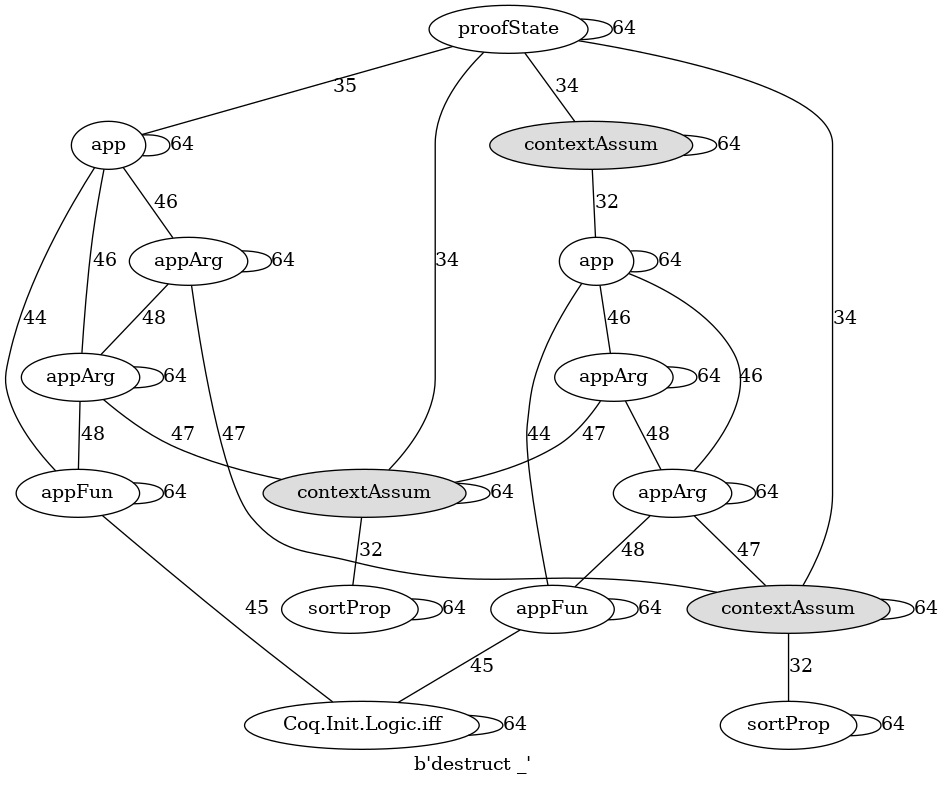

In [35]:
draw_proofstate(graph_tensor, dataset.graph_constants())

### <a id="data_inspection_definitions">Definitions</a> [↑](#contents)

Definition cluster graphs can be inspected in a similar fashion:

In [36]:
dataset_iterator = iter(definition_dataset)

2022-08-02 16:12:14.726603: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [37]:
graph_tensor = next(dataset_iterator)
graph_tensor

LOADING | requested 686


100%|██████████████████████████████████████████████████████████████████████████████| 686/686 [00:00<00:00, 12425.80it/s]


GraphTensor(
  context=Context(features={'num_definitions': <tf.Tensor: shape=(1,), dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

They are essentially similar to the proof-state graphs, except the context now contains an integer value `'num_definitions'`, specifying the number of node labels defined by this cluster:

In [38]:
graph_tensor.context['num_definitions']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([257])>

By convention, the node labels being defined are the first `num_definitions` node labels in the order in which the nodes are listed, and can be extracted like so:

In [39]:
tf.gather(graph_tensor.node_sets['node']['node_label'], tf.range(graph_tensor.context['num_definitions']))

<tf.Tensor: shape=(257,), dtype=int64, numpy=
array([ 765,  766,  767,  768,  769,  770,  771,  772,  773,  774,  775,
        776,  777,  778,  779,  780,  781,  782,  783,  784,  785,  786,
        787,  788,  789,  790,  791,  792,  793,  794,  795,  796,  797,
        798,  799,  800,  801,  802,  803,  804,  805,  806,  807,  808,
        809,  810,  811,  812,  813,  814,  815,  816,  817,  818,  819,
        820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,
        831,  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,
        842,  843,  844,  845,  846,  847,  848,  849,  850,  851,  852,
        853,  854,  855,  856,  857,  858,  859,  860,  861,  862,  863,
        864,  865,  866,  867,  868,  869,  870,  871,  872,  873,  874,
        875,  876,  877,  878,  879,  880,  881,  882,  883,  884,  885,
        886,  887,  888,  889,  890,  891,  892,  893,  894,  895,  896,
        897,  898,  899,  900,  901,  902,  903,  904,  905,  906,  907,
     

## <a id="data_statistics">Data statistics</a> [↑](#contents)

We can compute basic statistics about the datasets like so:

In [41]:
dataset.stats()

{'train_proofstates': {'num_graphs': 2046,
  'num_nodes': 240946,
  'min_num_nodes': 4,
  'max_num_nodes': 842,
  'num_edges': 1167832,
  'min_num_edges': 14,
  'max_num_edges': 4072,
  'mean_num_nodes': 117.7644183773216,
  'mean_num_edges': 570.7878787878788,
  'num_arguments': 1231,
  'num_local_arguments': 599,
  'num_global_arguments': 1169,
  'num_local_proofstates': 1420,
  'num_global_proofstates': 1984},
 'valid_proofstates': {'num_graphs': 220,
  'num_nodes': 25204,
  'min_num_nodes': 4,
  'max_num_nodes': 842,
  'num_edges': 122176,
  'min_num_edges': 14,
  'max_num_edges': 4072,
  'mean_num_nodes': 114.56363636363636,
  'mean_num_edges': 555.3454545454546,
  'num_arguments': 143,
  'num_local_arguments': 63,
  'num_global_arguments': 136,
  'num_local_proofstates': 141,
  'num_global_proofstates': 213},
 'definitions': {'num_graphs': 686,
  'num_nodes': 133357,
  'min_num_nodes': 2,
  'max_num_nodes': 1024,
  'num_edges': 571507,
  'min_num_edges': 4,
  'max_num_edges': 510

These represent:
- `num_graphs`: the total number of graphs in the dataset
- `num_nodes`: the total number of nodes in the dataset's graphs
- `min_num_nodes`: the minimum number of nodes in any graph in the dataset
- `max_num_nodes`: the maximum number of nodes in any graph in the dataset
- `mean_num_nodes`: the average number of nodes in all graphs in the dataset
- `num_edges`: the total number of edges in the dataset's graphs
- `min_num_edges`: the minimum number of edges in any graph in the dataset
- `max_num_edges`: the maximum number of edges in any graph in the dataset
- `mean_num_nodes`: the average number of edges in all graphs in the dataset
- `num_arguments`: the total number of arguments in all the (proofstate) graphs in the dataset
- `num_local_arguments`: the number of local arguments which are not `None` in all of the (proofstate) graphs in the dataset
- `num_global_arguments`: the number of arguments which are not `None` in all of the (proofstate) graphs in the dataset (local or global)
- `num_local_proofstates`: the number of proofstate graphs in the dataset which do not contain any `None` or global arguments
- `num_global_proofstates`: the number of proofstate graphs in the dataset which do not contain any `None` arguments
- `num_definitions`: the number of node labels defined by all definition graphs

# <a id='prediction_tasks'>Prediction tasks</a> [↑](#contents)

The fundamental objects we will deal with are derived from the `PredictionTask` class, which encapsulates most of the information we need for training and inference.

There are currently three subclasses of `PredictionTask`:
- [`TacticPrediction` for base tactic prediction](#tactic_prediction)
- [`LocalArgumentPrediction` for the prediction of both the base tactic and the local arguments](#local_argument_prediction)
- [`GlobalArgumentPrediction` for the prediction of both the base tactic and the global arguments](#global_argument_prediction)

## <a id="tactic_prediction">The `TacticPrediction` task</a> [↑](#contents)

As a first example, let's look into the base tactic prediction task:

In [55]:
tactic_task = TacticPrediction(graph_constants=dataset.graph_constants(),
                               hidden_size=128,
                               tactic_embedding_size=128,
                               gnn_type=SIMPLE_CONVOLUTION_GNN,
                               gnn_config={
                                   'hops': 8,
                                   'dense_activation': 'relu',
                                   'residual_activation': 'relu',
                                   'dropout_rate': 0.1,
                                   'layer_norm': True,
                                   'reduce_type': 'max',
                                   'final_reduce_type': 'attention'
                               },
                               tactic_head_type=DENSE_TACTIC,
                               tactic_head_config={
                                   'hidden_layers':[{'units': 256, 'activation': 'relu'}]
                               }
                              )

Some of the parameters above define the actual model to use:
- `gnn_type` defines the GNN component of the model, with hyperparameters passed in `gnn_config`
- `tactic_head_type` defines the tactic prediction head, with hyperparameters passed in `tactic_head_config`

See `graph2tac.tfgnn.models` for all available options you can use for these arguments, and their corresponding hyperparameters.

The other parameters are:
- `graph_constants`: provides basic information about the `GraphTensor` objects that constitute the input (this comes from the dataset, see previous section)
- `hidden_size`: the size of the hidden states, which is the same for the various model components
- `tactic_embedding_size`: the size of the hidden state representing tactics (which is also used when predicting arguments)

For convenience, tasks can also be created from YAML configuration files:

In [56]:
tactic_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                              yaml_filepath=Path('../graph2tac/tfgnn/default_tactic_prediction.yml'))

### <a id="tactic_prediction_task_inspection">Task inspection</a> [↑](#contents)

When a task is instantiated, a Keras model named `prediction_model` is created for later use with the Keras `fit` training framework:

In [57]:
tactic_task.prediction_model

In the case of the `TacticPrediction` task, this model takes a `GraphTensor` as input:

In [58]:
tactic_task.prediction_model.inputs

[<KerasTensor: type_spec=GraphTensorSpec({'context': ContextSpec({'features': {'context_node_ids': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'tactic': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'local_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'global_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'node': NodeSetSpec({'features': {'node_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None)}, 'edge_sets': {'edge': EdgeSetSpec({'features': {'edge_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': Ragged

and produces a vector of tactic logits as output:

In [59]:
tactic_task.prediction_model.outputs

[<KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'tactic_logits')>]

Notice the number of logits corresponds to the total number of base tactics

In [60]:
dataset.graph_constants().tactic_num

49

We can inspect the model as usual:

In [61]:
tactic_task.prediction_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 proofstate_graph (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 input.merge_batch_to_component  ()                  0           ['proofstate_graph[0][0]']       
 s_3 (InstanceMethod)                                                                             
                                                                                                  
 input.edge_sets_3 (InstancePro  {'edge': ()}        0           ['input.merge_batch_to_components
 perty)                                                          _3[0][0]']                       
                                                                                            

Its basic components are a GNN and a base tactic prediction head

In [62]:
tactic_task.gnn

In [63]:
tactic_task.tactic_head

### <a id="tactic_prediction_data_preparation">Data preparation</a> [↑](#contents)

`PredictionTask` objects have a `create_input_output` method that can be used to prepare the datasets we obtained in the previous section for training with the Keras `fit` training framework (producing input-output pairs for supervised training)

In [64]:
tactic_train_dataset = train_proofstates.map(tactic_task.create_input_output)
tactic_valid_dataset = valid_proofstates.map(tactic_task.create_input_output)

Exploring these datasets we see that there is a single input, corresponding to the `GraphTensor` object, and also a single output, corresponding to the base tactic we are supposed to predict:

In [65]:
inputs, outputs = next(iter(tactic_train_dataset))

2022-08-02 16:16:23.073340: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [66]:
inputs

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

In [67]:
outputs

{'tactic_logits': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([29])>}

Notice that above, the `'tactic_logits'` key means that this output should be matched to the (sparse categorical crossentropy) loss that goes with the tactic logits output of our model, see below.

### <a id="tactic_prediction_training">Training</a> [↑](#contents)

`PredictionTask` objects additionally provide the losses, loss weights, metrics and callbacks for use with the Keras `fit` training framework

In [68]:
tactic_task.loss()

{'tactic_logits': <keras.losses.SparseCategoricalCrossentropy at 0x7fed816228c0>}

In [69]:
tactic_task.loss_weights()

{'tactic_logits': 1.0}

In [70]:
tactic_task.metrics()

{'tactic_logits': [<keras.metrics.metrics.SparseCategoricalAccuracy at 0x7fed816215d0>]}

In [71]:
tactic_task.callbacks()

[]

To train the model, we first need to compile it

In [72]:
tactic_task.prediction_model.compile(optimizer='adam',
                                     loss=tactic_task.loss(),
                                     loss_weights=tactic_task.loss_weights(),
                                     metrics=tactic_task.metrics())

Then, we need to batch the datasets

In [73]:
batch_size = 64
batched_tactic_train_dataset = tactic_train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
batched_tactic_valid_dataset = tactic_valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

And finally we call the `fit` method

In [74]:
tactic_task.prediction_model.fit(batched_tactic_train_dataset,
                                 epochs=10,
                                 validation_data=batched_tactic_valid_dataset,
                                 callbacks=tactic_task.callbacks())

Epoch 1/10


/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/simple_convolution_gnn/graph_update_31/node_set_update_7/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/simple_convolution_gnn/graph_update_31/node_set_update_7/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/simple_convolution_gnn/graph_update_31/node_set_update_7/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/simple_convolution_gnn/graph_update_3

32/32 [==============================] - 13s 226ms/step - loss: 2.3560 - accuracy: 0.3935 - val_loss: 1.9546 - val_accuracy: 0.5591
Epoch 2/10
32/32 [==============================] - 5s 146ms/step - loss: 1.8015 - accuracy: 0.5489 - val_loss: 1.7291 - val_accuracy: 0.5818
Epoch 3/10
32/32 [==============================] - 5s 146ms/step - loss: 1.6001 - accuracy: 0.5782 - val_loss: 1.5399 - val_accuracy: 0.6182
Epoch 4/10
32/32 [==============================] - 5s 146ms/step - loss: 1.4509 - accuracy: 0.6007 - val_loss: 1.4641 - val_accuracy: 0.6136
Epoch 5/10
32/32 [==============================] - 5s 146ms/step - loss: 1.3409 - accuracy: 0.6246 - val_loss: 1.3721 - val_accuracy: 0.6545
Epoch 6/10
32/32 [==============================] - 5s 148ms/step - loss: 1.2623 - accuracy: 0.6388 - val_loss: 1.3726 - val_accuracy: 0.6318
Epoch 7/10
32/32 [==============================] - 5s 148ms/step - loss: 1.1864 - accuracy: 0.6505 - val_loss: 1.3330 - val_accuracy: 0.6091
Epoch 8/10
32/32

### <a id="tactic_prediction_checkpointing">Checkpointing</a> [↑](#contents)

`PredictionTask` objects have a `checkpoint` attribute corresponding to a `tf.train.Checkpoint` one can use to read and write checkpoints.

Use the `write` method to dump model weights to disk

In [75]:
tactic_task.checkpoint.write('../../logs/tactic_prediction_simple_checkpoint')

'../../logs/tactic_prediction_simple_checkpoint'

We can now create a new model, which will be originally untrained

In [76]:
tactic_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                              yaml_filepath=Path('../graph2tac/tfgnn/default_tactic_prediction.yml'))

The `read` method is then used to load weights from disk, returning a `CheckpointLoadStatus ` object

In [77]:
load_status = tactic_task.checkpoint.read('../../logs/tactic_prediction_simple_checkpoint')
load_status

which we can then use to check that the loading worked (and perform the operation immediately, instead of deferring it until it's absolutely necessary):

In [78]:
load_status.expect_partial().run_restore_ops()

**NOTE:** Here and elsewhere, for checkpoint loading to work the `PredictionTask` must have the same underlying model as the checkpoint that we want to use: the checkpoint does not include the model's architecture, only the model's weights, so any changes in architecture would break the whole process (although partial loading might occur). Layer naming should therefore always be consistent.

As will be seen later, [the `Trainer` class](#trainer) can be used to streamline training, optionally saving checkpoints along the way. These can be reloaded as follows:

In [79]:
tactic_task.from_trainer_checkpoint('../../logs/tactic_test/ckpt/ckpt-25')

### <a id="tactic_prediction_evaluation">Evaluation</a> [↑](#contents)

We can further evaluate the model using other metrics which are not included by default in `task.metrics()`. In order to do this, we first define the Keras metric we are interested in:

In [87]:
top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_accuracy')

Then we recompile the model with this metric:

In [88]:
tactic_task.prediction_model.compile(metrics=top5_accuracy)

and finally run the Keras `evaluate` method

In [89]:
tactic_task.prediction_model.evaluate(batched_tactic_valid_dataset, return_dict=True)

5/5 [==============================] - 1s 42ms/step - loss: 0.0000e+00 - top5_accuracy: 0.9364


{'loss': 0.0, 'top5_accuracy': 0.9363636374473572}

New metrics can be sub-classed from `tf.keras.metrics.Metric` and used in the same way, see for example the definition of `SparseCategoricalConfusionMatrix` in `graph2tac.tfgnn.metrics`

In [90]:
confusion_matrix = SparseCategoricalConfusionMatrix(num_categories=dataset.graph_constants().tactic_num)

In [91]:
tactic_task.prediction_model.compile(metrics=confusion_matrix)

In [92]:
tactic_task.prediction_model.evaluate(batched_tactic_valid_dataset)

4/4 [==============================] - 1s 58ms/step - loss: 0.0000e+00 - confusion_matrix: 0.0137


[0.0,
 array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0.8, 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32)]

Here we plot the non-trivial predictions

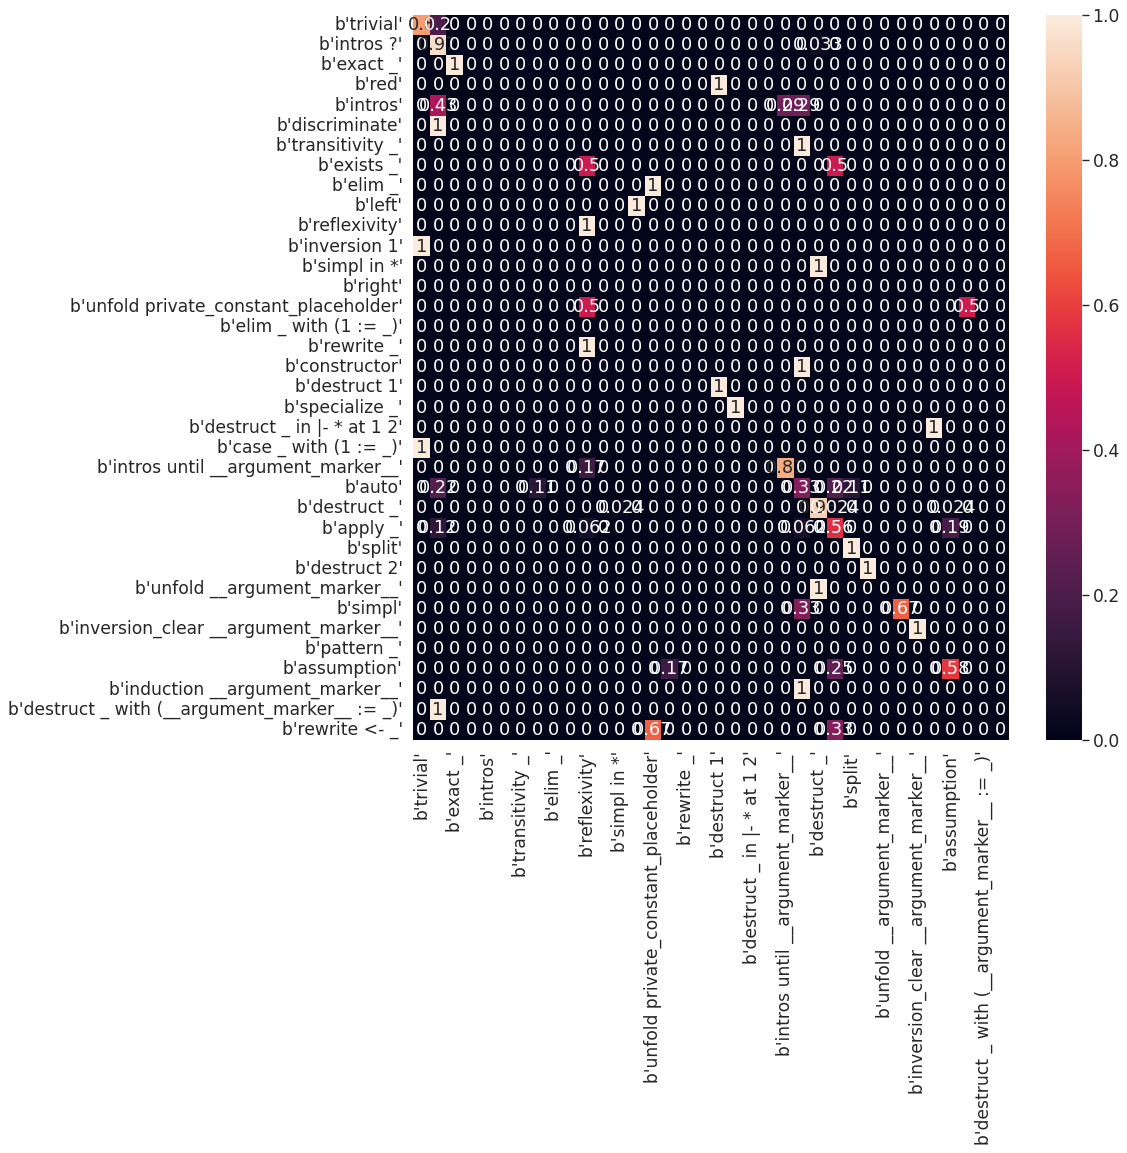

In [93]:
tactic_names = dataset.graph_constants().tactic_index_to_string
confusion_matrix_df = pd.DataFrame(confusion_matrix.result(), tactic_names, tactic_names)
non_empty = ~((confusion_matrix_df==0).all(axis=0) & (confusion_matrix_df==0).all(axis=1))
confusion_matrix_df = confusion_matrix_df.loc[non_empty,non_empty]

plt.figure(figsize=(12,12), dpi=80)
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_df, annot_kws={"size": 16}, annot=True)
plt.show()

## <a id="local_argument_prediction">The `LocalArgumentPrediction` task</a> [↑](#contents)

The `LocalArgumentPrediction` task works in a very similar fashion to the `TacticPrediction` task, except upon construction we need to provide a function to create the argument head (producing hidden states for each argument position):

In [94]:
local_argument_task = LocalArgumentPrediction(graph_constants=dataset.graph_constants(),
                                              hidden_size=128,
                                              tactic_embedding_size=128,
                                              gnn_type=ATTENTION_GNN,
                                              gnn_config={
                                                  'hops': 8,
                                                  'final_reduce_type': 'attention',
                                                  'attention_config': {}
                                              },
                                              tactic_head_type=DENSE_TACTIC,
                                              tactic_head_config={
                                                  'hidden_layers': [{'units': 256, 'activation': 'relu'}]
                                              },
                                              arguments_head_type=SIMPLE_RNN,
                                              arguments_head_config={
                                                  'activation': 'relu',
                                                  'recurrent_depth': 2,
                                                  'recurrent_activation': 'tanh'
                                              },
                                              arguments_loss_coefficient=1.0
                                             )

The new arguments above are:
- `arguments_head_type`, specifying the type of arguments head to use (with hyperparameters provided by `arguments_head_config`)
- `arguments_loss_coefficient`, specifying the coefficient in front of the (sparse categorical crossentropy) loss term for the arguments, where the normalization is given by a unit coefficient in front of the corresponding term for the base tactic

Again, for convenience we can also use the `from_yaml_config` method to instantiate the task from a YAML configuration file:

In [95]:
local_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                      yaml_filepath=Path('../graph2tac/tfgnn/default_local_argument_prediction.yml'))

### <a id="local_argument_prediction_task_inspection">Task inspection</a> [↑](#contents)

The `prediction_model` now also includes the arguments head which produces logits for each node in the local context:

In [96]:
local_argument_task.prediction_model.summary()

Model: "local_argument_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 proofstate_graph (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 input.merge_batch_to_component  ()                  0           ['proofstate_graph[0][0]']       
 s_6 (InstanceMethod)                                                                             
                                                                                                  
 input.edge_sets_6 (InstancePro  {'edge': ()}        0           ['input.merge_batch_to_components
 perty)                                                          _6[0][0]']                       
                                                                             

The task's `prediction_model` again has a single input (the proof-state graph), but now includes two outputs (the tactic logits and the logits for each local context node to be chosen for each argument position):

In [97]:
local_argument_task.prediction_model.inputs

[<KerasTensor: type_spec=GraphTensorSpec({'context': ContextSpec({'features': {'context_node_ids': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'tactic': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'local_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'global_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'node': NodeSetSpec({'features': {'node_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None)}, 'edge_sets': {'edge': EdgeSetSpec({'features': {'edge_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': Ragged

In [98]:
local_argument_task.prediction_model.outputs

[<KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'arguments_logits')>,
 <KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'tactic_logits')>]

The new output above is `arguments_logits`, with shape corresponding to `(batch_size, num_arguments, local_context_size)`.

**NOTE:** The model is _weakly autoregressive_, in the sense that the arguments are computed assuming the correct base tactic has been chosen (the `prediction_model` takes care of implementing this behind-the-scenes). Therefore, for inference purposes we need to implement a decoder, see the section on the [`Predict` class](#predict) for more details.

Again, one can access the individual componens if necessary; the new one is

In [99]:
local_argument_task.arguments_head

### <a id="local_argument_prediction_data_preparation">Data preparation</a> [↑](#contents)

As before, we prepare the training and validation data using the `create_input_output` method:

In [100]:
local_argument_train_dataset = train_proofstates.map(local_argument_task.create_input_output)
local_argument_valid_dataset = valid_proofstates.map(local_argument_task.create_input_output)

To inspect some elements, create an iterator and extract from it the input-output pairs:

In [101]:
local_argument_train_dataset_iterator = iter(local_argument_train_dataset)

In [102]:
inputs, outputs = next(local_argument_train_dataset_iterator)

In [103]:
inputs

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

In [104]:
outputs

{'tactic_logits': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([35])>,
 'arguments_logits': <tf.RaggedTensor [[0]]>}

The new output named `'arguments_logits'` provides the ids of the nodes that should be chosen as arguments, in the order they should appear. These ids go from 0 to the number of nodes in the local context, and running the above a few times you may see values of `-1`, which encode `None` or global arguments. Predictions for these are discarded, so that they do **not** contribute to the loss or accuracy of the model.

### <a id="local_argument_prediction_training">Training</a> [↑](#contents)

Like the `TacticPrediction` tasks, `LocalArgumentPrediction` tasks provide everything you need to compile the model

In [105]:
local_argument_task.prediction_model.compile(optimizer='adam',
                                             loss=local_argument_task.loss(),
                                             loss_weights=local_argument_task.loss_weights(),
                                             metrics=local_argument_task.metrics())

We can then batch the datasets we prepared:

In [106]:
batch_size = 64
batched_local_argument_train_dataset = local_argument_train_dataset.batch(batch_size)
batched_local_argument_valid_dataset = local_argument_valid_dataset.batch(batch_size)

And finally train the model as usual

In [107]:
local_argument_task.prediction_model.fit(batched_local_argument_train_dataset,
                                         epochs=25,
                                         validation_data=batched_local_argument_valid_dataset,
                                         callbacks=local_argument_task.callbacks())

Epoch 1/25


/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), values=Tens

/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_argument_model_1/simple_convolution_gnn/graph_update_40/node_set_update/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/local_argument_model_1/simple_convolution_gnn/graph_update_40/node_set_update/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/local_argument_model_1/simple_convolution_gnn/graph_update_40/node_set_update/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_

32/32 [==============================] - 15s 237ms/step - loss: 2.6702 - arguments_logits_loss: 1.5199 - tactic_logits_loss: 2.5182 - arguments_logits_accuracy: 0.4942 - tactic_logits_accuracy: 0.2874 - arguments_seq_accuracy: 0.5533 - strict_accuracy: 0.1095 - val_loss: 2.4462 - val_arguments_logits_loss: 1.0628 - val_tactic_logits_loss: 2.3400 - val_arguments_logits_accuracy: 0.6032 - val_tactic_logits_accuracy: 0.3773 - val_arguments_seq_accuracy: 0.5318 - val_strict_accuracy: 0.1182
Epoch 2/25
32/32 [==============================] - 6s 174ms/step - loss: 2.1711 - arguments_logits_loss: 1.0766 - tactic_logits_loss: 2.0634 - arguments_logits_accuracy: 0.5492 - tactic_logits_accuracy: 0.4057 - arguments_seq_accuracy: 0.5684 - strict_accuracy: 0.1642 - val_loss: 2.3641 - val_arguments_logits_loss: 1.0268 - val_tactic_logits_loss: 2.2614 - val_arguments_logits_accuracy: 0.7143 - val_tactic_logits_accuracy: 0.3864 - val_arguments_seq_accuracy: 0.5636 - val_strict_accuracy: 0.1273
Epoch 

### <a id="local_argument_prediction_checkpointing">Checkpointing</a> [↑](#contents)

Checkpoints work identically to the `TacticPrediction` task, _e.g._ use `checkpoint.write` to dump a checkpoint to disk

In [108]:
local_argument_task.checkpoint.write('../../logs/local_argument_prediction_simple_checkpoint')

'../../logs/local_argument_prediction_simple_checkpoint'

Then after creating a new model, you can use `checkpoint.read` to load back its weights from disk

In [109]:
local_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                yaml_filepath=Path('../graph2tac/tfgnn/default_local_argument_prediction.yml'))

In [110]:
load_status = local_argument_task.checkpoint.read('../../logs/local_argument_prediction_simple_checkpoint')
load_status.expect_partial().run_restore_ops()

For training checkpoints there is again the `from_trainer_checkpoint` method

In [112]:
local_argument_task.from_trainer_checkpoint('../../logs/local_argument_test/ckpt/ckpt-25')

### <a id="local_argument_prediction_evaluation">Evaluation</a> [↑](#contents)

For evaluation purposes, when dealing with local argument predictions it is often convenient to extract the valid (_i.e._ not `None` or global) arguments, as well as their corresponding logits. The `graph2tac.tfgnn.tasks` module defines an `arguments_filter` method to do exactly this

In [113]:
inputs, outputs = next(iter(batched_local_argument_train_dataset))

In [114]:
model_outputs = local_argument_task.prediction_model(inputs)

In [115]:
arguments_filter(y_true=outputs[local_argument_task.ARGUMENTS_LOGITS], 
                 y_pred=model_outputs[local_argument_task.ARGUMENTS_LOGITS])

(<tf.Tensor: shape=(19,), dtype=int64, numpy=array([0, 5, 0, 2, 2, 1, 2, 1, 1, 7, 3, 5, 0, 5, 3, 5, 4, 3, 1])>,
 <tf.Tensor: shape=(19, 10), dtype=float32, numpy=
 array([[ -3.3586354 ,         -inf,         -inf,         -inf,
                 -inf,         -inf,         -inf,         -inf,
                 -inf,         -inf],
        [-10.647289  , -11.897226  , -12.120823  , -11.3860035 ,
         -11.389124  ,  -6.7465944 ,         -inf,         -inf,
                 -inf,         -inf],
        [ -0.5744889 ,         -inf,         -inf,         -inf,
                 -inf,         -inf,         -inf,         -inf,
                 -inf,         -inf],
        [-10.169306  ,  -6.1936717 ,  -6.0356035 , -10.725933  ,
          -9.63605   ,  -9.682462  ,         -inf,         -inf,
                 -inf,         -inf],
        [-14.221721  , -14.260862  ,  -6.9637346 ,         -inf,
                 -inf,         -inf,         -inf,         -inf,
                 -inf,         -inf

The returned tuple contains the node ids for the local arguments (as they appear in the local context, first element); and the logits for each local context node to correspond to each local argument (filled with `-inf` to fit a rectangular tensor, second element).

We can use this method to define simple wrappers around other metrics

In [116]:
class ArgumentSparseTopKCategoricalAccuracy(tf.keras.metrics.SparseTopKCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        arguments_true, arguments_pred = arguments_filter(y_true, y_pred)
        if tf.shape(arguments_pred)[-1] > 0:
            super().update_state(arguments_true, tf.math.softmax(arguments_pred, axis=-1), sample_weight)

These can then be used as before to evaluate the model

In [117]:
top5_accuracy = ArgumentSparseTopKCategoricalAccuracy(k=5, name='top5_accuracy')

In [118]:
local_argument_task.prediction_model.compile(metrics={local_argument_task.ARGUMENTS_LOGITS: top5_accuracy})

In [119]:
local_argument_task.prediction_model.evaluate(batched_local_argument_valid_dataset,
                                              callbacks=local_argument_task.callbacks(),
                                              return_dict=True)

4/4 [==============================] - 2s 68ms/step - loss: 0.0000e+00 - arguments_logits_top5_accuracy: 0.9683 - arguments_seq_accuracy: 0.5636 - strict_accuracy: 0.3955


{'loss': 0.0,
 'arguments_logits_top5_accuracy': 0.9682539701461792,
 'arguments_seq_accuracy': 0.5636363625526428,
 'strict_accuracy': 0.3954545557498932}

An example of a more involved metric is the `FullLocalArgumentSparseCategoricalAccuracy` found in `graph2tac.tfgnn.metrics`

This metric measures the accuracy for predicting the full sequence of arguments, of course discarding target sequences containing invalid arguments which the network could never predict. We have the possibility to choose one of three different weighting schemes:
- `'non-empty'` only considers non-empty sequences of arguments
- `'length'` weighs each sequence using its length (so empty sequences do not contribute, and longer sequences contribute more than short ones)
- `None` weights all sequences uniformly, including the empty ones

In [120]:
nonempty_accuracy = FullLocalArgumentSparseCategoricalAccuracy(weighting_scheme='non-empty', name='nonempty_accuracy')
length_accuracy = FullLocalArgumentSparseCategoricalAccuracy(weighting_scheme='length', name='length_weighted_accuracy')
absolute_accuracy = FullLocalArgumentSparseCategoricalAccuracy(weighting_scheme=None, name='absolute_accuracy')
all_accuracies = [nonempty_accuracy, length_accuracy, absolute_accuracy]

In [121]:
local_argument_task.prediction_model.compile(metrics={local_argument_task.ARGUMENTS_LOGITS: all_accuracies})

In [122]:
local_argument_task.prediction_model.evaluate(batched_local_argument_valid_dataset, 
                                              callbacks=local_argument_task.callbacks(),
                                              return_dict=True)

4/4 [==============================] - 3s 78ms/step - loss: 0.0000e+00 - arguments_logits_nonempty_accuracy: 0.7213 - arguments_logits_length_weighted_accuracy: 0.7213 - arguments_logits_absolute_accuracy: 0.8794 - arguments_seq_accuracy: 0.5636 - strict_accuracy: 0.3955


{'loss': 0.0,
 'arguments_logits_nonempty_accuracy': 0.7213114500045776,
 'arguments_logits_length_weighted_accuracy': 0.7213114500045776,
 'arguments_logits_absolute_accuracy': 0.8794326186180115,
 'arguments_seq_accuracy': 0.5636363625526428,
 'strict_accuracy': 0.3954545557498932}

As expected, we see that the absolute accuracy is highest, because many argument sequences are actually empty so trivially correct. Moreover, the non-empty accuracy is greater than the length-weighted accuracy, since long sequences weigh more in the latter and are presumably harder to get right.

Of course, metrics on the tactic logits work as before

In [123]:
confusion_matrix = SparseCategoricalConfusionMatrix(num_categories=dataset.graph_constants().tactic_num)

In [124]:
local_argument_task.prediction_model.compile(metrics={local_argument_task.TACTIC_LOGITS: confusion_matrix})

In [125]:
local_argument_task.prediction_model.evaluate(batched_local_argument_valid_dataset,
                                              callbacks=local_argument_task.callbacks(),
                                              return_dict=True)

4/4 [==============================] - 2s 69ms/step - loss: 0.0000e+00 - tactic_logits_confusion_matrix: 0.0137 - arguments_seq_accuracy: 0.5636 - strict_accuracy: 0.3955


{'loss': 0.0,
 'tactic_logits_confusion_matrix': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0.8, 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32),
 'arguments_seq_accuracy': 0.5636363625526428,
 'strict_accuracy': 0.3954545557498932}

Here we plot the non-empty predictions

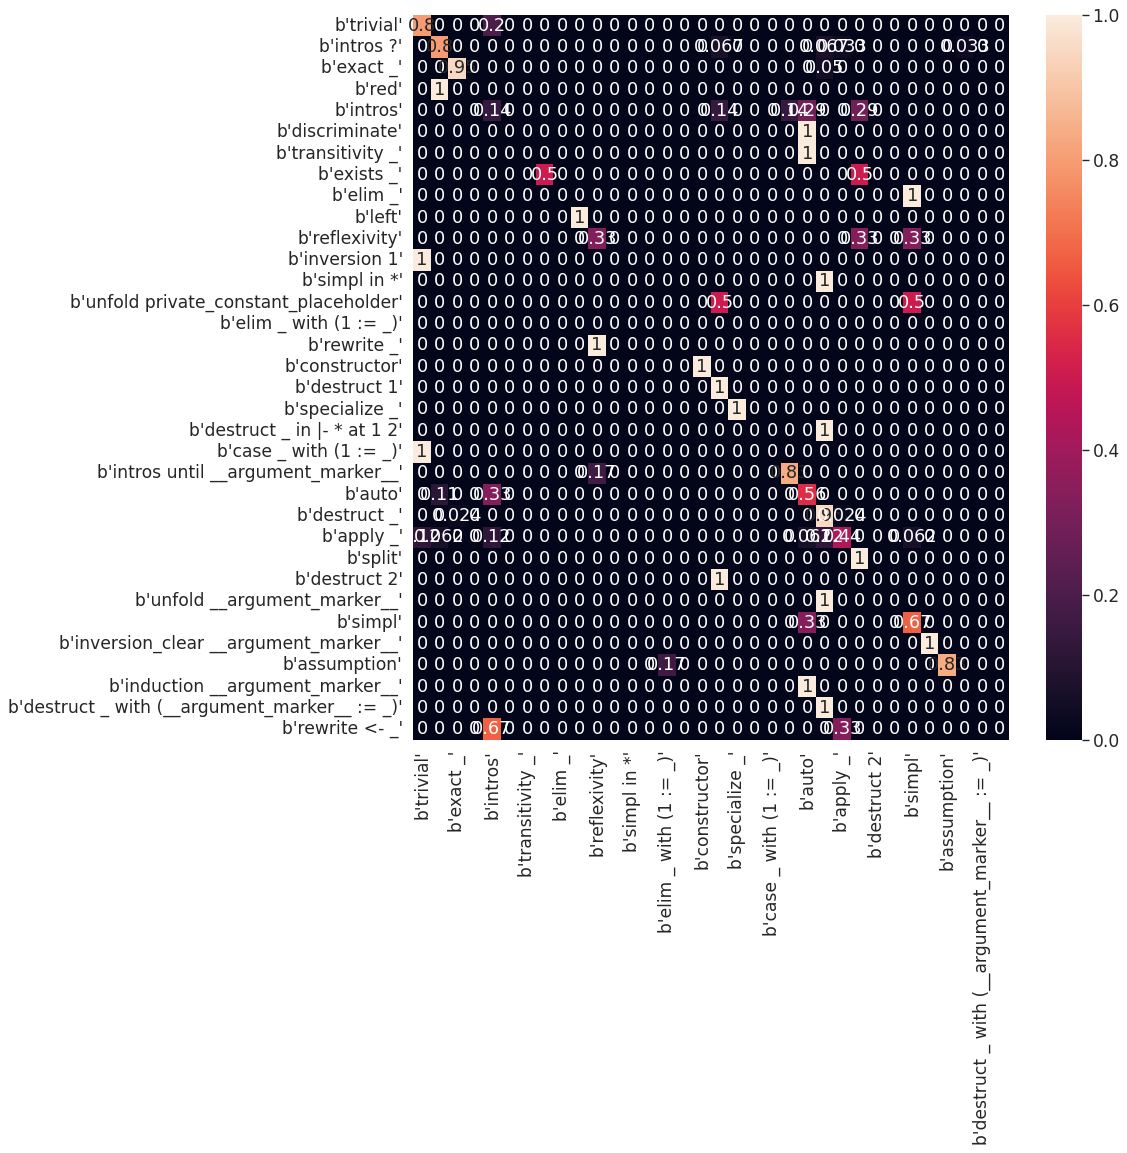

In [126]:
tactic_names = dataset.graph_constants().tactic_index_to_string
confusion_matrix_df = pd.DataFrame(confusion_matrix.result(), tactic_names, tactic_names)
non_empty = ~((confusion_matrix_df==0).all(axis=0) & (confusion_matrix_df==0).all(axis=1))
confusion_matrix_df = confusion_matrix_df.loc[non_empty,non_empty]

plt.figure(figsize=(12,12), dpi=80)
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_df, annot_kws={"size": 16}, annot=True)
plt.show()

**NOTE:** Keras' `fit` and `evaluate` methods operate with metrics working with a single output and not depending on the input. To define more complex metrics, involving multiple outputs or the model's input, one has to override the `compute_metrics` method. When doing this, it may be necessary to include additional callbacks to make sure these metrics are reset before each epoch / test run, since they were not passed as arguments to `compile` and therefore the resetting won't be automatic. This is the reason why in the calls to `evaluate` before we always include the `task.callbacks()`, which in this case handle the correct computation of the strict accuracy.

## <a id="global_argument_prediction">The `GlobalArgumentPrediction` task</a> [↑](#contents)

The `GlobalArgumentPrediction` class works essentially like the `LocalArgumentPrediction` of the previous section. We can again create it providing the same arguments to the constructor:

In [127]:
global_argument_task = GlobalArgumentPrediction(graph_constants=dataset.graph_constants(),
                                                hidden_size=128,
                                                tactic_embedding_size=128,
                                                gnn_type=ATTENTION_GNN,
                                                gnn_config={
                                                    'hops': 8,
                                                    'final_reduce_type': 'attention',
                                                    'attention_config': {}
                                                },
                                                tactic_head_type=DENSE_TACTIC,
                                                tactic_head_config={
                                                    'hidden_layers': [{'units': 256, 'activation': 'relu'}]
                                                },
                                                arguments_head_type=SIMPLE_RNN,
                                                arguments_head_config={
                                                    'activation': 'relu',
                                                    'recurrent_depth': 2,
                                                    'recurrent_activation': 'tanh'
                                                },
                                                arguments_loss_coefficient=1.0
                                               )

Or using YAML configuration files

In [128]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

**NOTE:** The `arguments_loss_coefficient` controls the coefficient in front of the loss term for both global and local arguments, although in principle we could differentiate these.

### <a id="global_argument_prediction_task_inspection">Task inspection</a> [↑](#contents)

The task's `prediction_model` is essentially the same as the one we used for local argument predictions:

In [129]:
global_argument_task.prediction_model.summary()

Model: "global_argument_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 proofstate_graph (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 input.merge_batch_to_component  ()                  0           ['proofstate_graph[0][0]']       
 s_9 (InstanceMethod)                                                                             
                                                                                                  
 input.edge_sets_9 (InstancePro  {'edge': ()}        0           ['input.merge_batch_to_components
 perty)                                                          _9[0][0]']                       
                                                                            

                                 'global_arguments'                                               
                                : (None, None)}                                                   
                                                                                                  
 embedding_9 (Embedding)        (None, 128)          6272        ['input._get_features_ref_43[0][3
                                                                 ]']                              
                                                                                                  
 tf.compat.v1.gather_5 (TFOpLam  (None,)             0           ['input._get_features_ref_43[0][3
 bda)                                                            ]']                              
                                                                                                  
 tf.compat.v1.gather_6 (TFOpLam  (None, None, 128)   0           ['input._get_features_ref_45[0][0
 bda)     

                                                                                                  
Total params: 952,452
Trainable params: 952,448
Non-trainable params: 4
__________________________________________________________________________________________________


There are no new components in the model, but now we have three outputs instead of two (the new one corresponding to `global_arguments_logits`):

In [130]:
global_argument_task.prediction_model.outputs

[<KerasTensor: shape=(None, None, 1002) dtype=float32 (created by layer 'global_arguments_logits')>,
 <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'local_arguments_logits')>,
 <KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'tactic_logits')>]

Notice the shape of the new `global_arguments_logits` output corresponds to `(batch_size, num_arguments, global_context_size)`.

### <a id="global_argument_prediction_data_preparation">Data preparation</a> [↑](#contents)

The workflow remains the same, _i.e._ first we prepare the data:

In [131]:
global_argument_train_dataset = train_proofstates.map(global_argument_task.create_input_output)
global_argument_valid_dataset = valid_proofstates.map(global_argument_task.create_input_output)

Then we can inspect it as usual:

In [132]:
global_argument_train_dataset_iterator = iter(global_argument_train_dataset)

In [133]:
inputs, outputs = next(global_argument_train_dataset_iterator)

In [134]:
inputs

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

In [135]:
outputs

{'tactic_logits': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([35])>,
 'local_arguments_logits': <tf.RaggedTensor [[0]]>,
 'global_arguments_logits': <tf.RaggedTensor [[-1]]>}

As seen above, for each argument position either `local_arguments_logits` or `global_arguments_logits` is different from `-1`, but not both. Wherever `local_arguments_logits` is not `-1` the corresponding id is as before a number from `0` to the number of nodes in the local context. Instead, whenever `global_arguments_logits` is not `-1` the corresponding id is a number from `0` to the total number of global definitions availble, which is the length of `graph_constants.global_context` and can also be computed as `graph_constants.node_type_num - graph_constants.base_node_type_num`. 

**NOTE:**
- The indices in `global_arguments_logits` should be considered pointers into `graph_constants.global_context`
- It is possible that both `local_arguments_logits` and `global_arguments_logits` are `-1`, which corresponds to a `None` argument (although these appear much less frequently than in the local argument prediction task).

### <a id="global_argument_prediction_training">Training</a> [↑](#contents)

The `GlobalArgumentPrediction` task provides everything we need to train the `prediction_model`. We first need to compile it

In [136]:
global_argument_task.prediction_model.compile(optimizer='adam',
                                              loss=global_argument_task.loss(),
                                              loss_weights=global_argument_task.loss_weights(),
                                              metrics=global_argument_task.metrics())

Then we prepare the data as we did before for the `LocalArgumentPrediction` task:

In [137]:
batch_size = 64
batched_global_argument_train_dataset = global_argument_train_dataset.batch(batch_size)
batched_global_argument_valid_dataset = global_argument_valid_dataset.batch(batch_size)

Finally we use Keras' `fit` method to train the `prediction_model`:

In [138]:
global_argument_task.prediction_model.fit(batched_global_argument_train_dataset,
                                          epochs=25,
                                          validation_data=batched_global_argument_valid_dataset,
                                          callbacks=global_argument_task.callbacks())

Epoch 1/25


/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), values=

/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_1/simple_convolution_gnn/graph_update_56/node_set_update/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_1/simple_convolution_gnn/graph_update_56/node_set_update/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_1/simple_convolution_gnn/graph_update_56/node_set_update/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/glo

32/32 [==============================] - 16s 250ms/step - loss: 3.1246 - global_arguments_logits_loss: 4.6164 - local_arguments_logits_loss: 1.7204 - tactic_logits_loss: 2.4910 - global_arguments_logits_accuracy: 0.7281 - local_arguments_logits_accuracy: 0.4808 - tactic_logits_accuracy: 0.2962 - arguments_seq_accuracy: 0.6168 - strict_accuracy: 0.1579 - val_loss: 2.8027 - val_global_arguments_logits_loss: 4.1778 - val_local_arguments_logits_loss: 0.9090 - val_tactic_logits_loss: 2.2940 - val_global_arguments_logits_accuracy: 0.7808 - val_local_arguments_logits_accuracy: 0.6349 - val_tactic_logits_accuracy: 0.3955 - val_arguments_seq_accuracy: 0.6227 - val_strict_accuracy: 0.3955
Epoch 2/25
32/32 [==============================] - 6s 185ms/step - loss: 2.2499 - global_arguments_logits_loss: 1.3316 - local_arguments_logits_loss: 1.4132 - tactic_logits_loss: 1.9754 - global_arguments_logits_accuracy: 0.8123 - local_arguments_logits_accuracy: 0.5309 - tactic_logits_accuracy: 0.4712 - argum

Epoch 13/25
32/32 [==============================] - 6s 184ms/step - loss: 1.0839 - global_arguments_logits_loss: 0.8371 - local_arguments_logits_loss: 0.6476 - tactic_logits_loss: 0.9354 - global_arguments_logits_accuracy: 0.8175 - local_arguments_logits_accuracy: 0.7295 - tactic_logits_accuracy: 0.7058 - arguments_seq_accuracy: 0.6378 - strict_accuracy: 0.4712 - val_loss: 1.5297 - val_global_arguments_logits_loss: 3.8108 - val_local_arguments_logits_loss: 0.4569 - val_tactic_logits_loss: 1.1029 - val_global_arguments_logits_accuracy: 0.7808 - val_local_arguments_logits_accuracy: 0.8254 - val_tactic_logits_accuracy: 0.7045 - val_arguments_seq_accuracy: 0.6227 - val_strict_accuracy: 0.4955
Epoch 14/25
32/32 [==============================] - 6s 183ms/step - loss: 1.0410 - global_arguments_logits_loss: 0.8240 - local_arguments_logits_loss: 0.6410 - tactic_logits_loss: 0.8945 - global_arguments_logits_accuracy: 0.8175 - local_arguments_logits_accuracy: 0.7145 - tactic_logits_accuracy: 0.

Epoch 25/25
32/32 [==============================] - 6s 183ms/step - loss: 0.7052 - global_arguments_logits_loss: 0.5873 - local_arguments_logits_loss: 0.5923 - tactic_logits_loss: 0.5872 - global_arguments_logits_accuracy: 0.8491 - local_arguments_logits_accuracy: 0.7195 - tactic_logits_accuracy: 0.7972 - arguments_seq_accuracy: 0.6432 - strict_accuracy: 0.5191 - val_loss: 1.4472 - val_global_arguments_logits_loss: 4.1466 - val_local_arguments_logits_loss: 0.6464 - val_tactic_logits_loss: 0.9679 - val_global_arguments_logits_accuracy: 0.7945 - val_local_arguments_logits_accuracy: 0.7143 - val_tactic_logits_accuracy: 0.7318 - val_arguments_seq_accuracy: 0.6227 - val_strict_accuracy: 0.5091


### <a id="global_argument_prediction_checkpointing">Checkpointing</a> [↑](#contents)

Checkpoints work identically to the other prediction tasks discussed in the previous sections, _e.g._ use `checkpoint.write` to dump a checkpoint to disk

In [139]:
global_argument_task.checkpoint.write('../../logs/global_argument_prediction_simple_checkpoint')

'../../logs/global_argument_prediction_simple_checkpoint'

Then when creating a new model, you can use `checkpoint.read` to load back its weights from disk

In [140]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

In [141]:
load_status = global_argument_task.checkpoint.read('../../logs/global_argument_prediction_simple_checkpoint')
load_status.expect_partial().run_restore_ops()

As usual, to load training checkpoints you should use the `from_trainer_checkpoint` method

In [142]:
global_argument_task.from_trainer_checkpoint('../../logs/global_argument_test/ckpt/ckpt-25')

### <a id="global_argument_prediction_evaluation">Evaluation</a> [↑](#contents)

For evaluation purposes, the `arguments_filter` method described in the [Evaluation section for the `LocalArgumentPrediction`](#local_argument_prediction_evaluation) task still works for both local and global arguments (we show it here only for the latter):

In [143]:
inputs, outputs = next(iter(batched_global_argument_train_dataset))

In [144]:
model_outputs = global_argument_task.prediction_model(inputs)

In [145]:
arguments_filter(y_true=outputs[global_argument_task.GLOBAL_ARGUMENTS_LOGITS], 
                 y_pred=model_outputs[global_argument_task.GLOBAL_ARGUMENTS_LOGITS])

(<tf.Tensor: shape=(20,), dtype=int64, numpy=
 array([ 77,  77,  95,  77,  77,  77, 666, 484,  77,  77,  77,  77,  77,
         77,  77,  77, 199,  77,  77,  77])>,
 <tf.Tensor: shape=(20, 1002), dtype=float32, numpy=
 array([[-17.188248, -17.46469 , -17.10807 , ..., -17.222084, -17.315521,
         -17.58136 ],
        [-17.19399 , -17.470673, -17.113888, ..., -17.22793 , -17.321236,
         -17.587109],
        [-11.573808, -11.559453, -11.611111, ..., -11.598063, -11.620111,
         -11.48069 ],
        ...,
        [-17.193243, -17.469566, -17.113031, ..., -17.227085, -17.320385,
         -17.586136],
        [-17.171375, -17.447227, -17.091396, ..., -17.205034, -17.298317,
         -17.563871],
        [-19.464985, -19.846634, -19.36244 , ..., -19.463793, -19.649267,
         -19.94942 ]], dtype=float32)>)

In fact, the simple wrapper around this method that we defined before, `ArgumentSparseTopKCategoricalAccuracy`, works without any further changes for both types of arguments:

In [146]:
top3_local_arguments_accuracy = ArgumentSparseTopKCategoricalAccuracy(k=3, name='top3_local_arguments_accuracy')
top10_global_arguments_accuracy = ArgumentSparseTopKCategoricalAccuracy(k=10, name='top10_global_arguments_accuracy')

In [147]:
global_argument_task.prediction_model.compile(metrics={
    global_argument_task.LOCAL_ARGUMENTS_LOGITS: top3_local_arguments_accuracy,
    global_argument_task.GLOBAL_ARGUMENTS_LOGITS: top10_global_arguments_accuracy,
})

In [148]:
global_argument_task.prediction_model.evaluate(batched_global_argument_valid_dataset,
                                               callbacks=global_argument_task.callbacks(),
                                               return_dict=True)

4/4 [==============================] - 3s 80ms/step - loss: 0.0000e+00 - global_arguments_logits_top10_global_arguments_accuracy: 0.8904 - local_arguments_logits_top3_local_arguments_accuracy: 0.9841 - arguments_seq_accuracy: 0.6227 - strict_accuracy: 0.5000


{'loss': 0.0,
 'global_arguments_logits_top10_global_arguments_accuracy': 0.8904109597206116,
 'local_arguments_logits_top3_local_arguments_accuracy': 0.9841269850730896,
 'arguments_seq_accuracy': 0.6227272748947144,
 'strict_accuracy': 0.5}

# <a id="trainer">The `Trainer` class</a> [↑](#contents)

`graph2tac.tfgnn.train` defines a `Trainer` class we can use to streamline the training process. Given a prediction task:

In [149]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

We can instantiate a `Trainer` as follows:

In [150]:
trainer = Trainer(dataset=dataset,
                  prediction_task=global_argument_task,
                  serialized_optimizer={'class_name': 'adam', 'config': {}},
                  l2_regularization_coefficient=1e-5,
                  log_dir=Path('../../logs/trainer_test'))

The arguments shown above are:
- `dataset`: the dataset to use
- `prediction_task`: the `PredictionTask` object we want to train
- `serialized_optimizer`: the optimizer to use, as serialized by `tf.keras.optimizers.serialize` (including _e.g._ a learning rate schedule)
- `l2_regularization_coefficient`: the $L_2$ regularization coefficient for all of the model's trainable weights
- `log_dir`: the path to a directory where logs and checkpoints will be stored

For convenience, we can also instantiate a trainer from YAML configuration files:

In [151]:
trainer = Trainer.from_yaml_config(dataset=dataset,
                                   trainer_config=Path('../graph2tac/tfgnn/default_trainer_config.yml'),
                                   prediction_task_config=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'),
                                   log_dir=Path('../../logs/trainer_test'))

graph2tac:INFO - Restored checkpoint ../../logs/trainer_test/ckpt/ckpt-0!
graph2tac:INFO - ../../logs/trainer_test/config/graph_constants.yaml already exists, renaming to ../../logs/trainer_test/config/graph_constants-0.yaml
graph2tac:INFO - ../../logs/trainer_test/config/dataset.yaml already exists, renaming to ../../logs/trainer_test/config/dataset-0.yaml
graph2tac:INFO - ../../logs/trainer_test/config/prediction.yaml already exists, renaming to ../../logs/trainer_test/config/prediction-0.yaml


## <a id="trainer_training">Training</a> [↑](#contents)

We can now run the trainer for some number of epochs

In [152]:
trainer.run(total_epochs=5,
            batch_size=64,
            split=(9,1),
            split_random_seed=0)

Epoch 1/5


/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), values=

/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_4/simple_convolution_gnn/graph_update_81/node_set_update_1/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_4/simple_convolution_gnn/graph_update_81/node_set_update_1/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_4/simple_convolution_gnn/graph_update_81/node_set_update_1/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_ta

32/32 [==============================] - 21s 304ms/step - loss: 3.2190 - global_arguments_logits_loss: 4.7622 - local_arguments_logits_loss: 1.6135 - tactic_logits_loss: 2.5401 - global_arguments_logits_accuracy: 0.7368 - local_arguments_logits_accuracy: 0.5209 - tactic_logits_accuracy: 0.2962 - arguments_seq_accuracy: 0.6232 - strict_accuracy: 0.1691 - val_loss: 2.9487 - val_global_arguments_logits_loss: 4.4816 - val_local_arguments_logits_loss: 0.9736 - val_tactic_logits_loss: 2.3617 - val_global_arguments_logits_accuracy: 0.7808 - val_local_arguments_logits_accuracy: 0.6190 - val_tactic_logits_accuracy: 0.3773 - val_arguments_seq_accuracy: 0.6227 - val_strict_accuracy: 0.3682 - epoch_duration: 20.7322 - learning_rate: 0.0010 - GPU:0_peak_memory: 1.3803
Epoch 2/5
32/32 [==============================] - 6s 197ms/step - loss: 2.3527 - global_arguments_logits_loss: 1.3195 - local_arguments_logits_loss: 1.4850 - tactic_logits_loss: 2.0307 - global_arguments_logits_accuracy: 0.8123 - loc

If we later decide we want to run for a few more epochs, the trainer will continue where it left off:

In [153]:
trainer.run(total_epochs=10,
            batch_size=64,
            split=(9,1),
            split_random_seed=0)

Epoch 6/10
32/32 [==============================] - 21s 313ms/step - loss: 1.7901 - global_arguments_logits_loss: 0.9778 - local_arguments_logits_loss: 0.8928 - tactic_logits_loss: 1.5613 - global_arguments_logits_accuracy: 0.8123 - local_arguments_logits_accuracy: 0.6160 - tactic_logits_accuracy: 0.5635 - arguments_seq_accuracy: 0.6378 - strict_accuracy: 0.3793 - val_loss: 2.1666 - val_global_arguments_logits_loss: 3.7943 - val_local_arguments_logits_loss: 0.8640 - val_tactic_logits_loss: 1.6590 - val_global_arguments_logits_accuracy: 0.7808 - val_local_arguments_logits_accuracy: 0.6190 - val_tactic_logits_accuracy: 0.5773 - val_arguments_seq_accuracy: 0.6227 - val_strict_accuracy: 0.4227 - epoch_duration: 21.0131 - learning_rate: 0.0010 - GPU:0_peak_memory: 1.2317
Epoch 7/10
32/32 [==============================] - 6s 198ms/step - loss: 1.6631 - global_arguments_logits_loss: 0.9429 - local_arguments_logits_loss: 0.8682 - tactic_logits_loss: 1.4402 - global_arguments_logits_accuracy: 

Even if we create a new trainer with a fresh prediction task, when passing the `log_dir` argument the latest checkpoint will be restored before we start training, so that we can continue from where we left off

In [154]:
trainer = Trainer.from_yaml_config(dataset=dataset,
                                   trainer_config=Path('../graph2tac/tfgnn/default_trainer_config.yml'),
                                   prediction_task_config=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'),
                                   log_dir=Path('../../logs/trainer_test'))

graph2tac:INFO - Restored checkpoint ../../logs/trainer_test/ckpt/ckpt-10!
graph2tac:INFO - ../../logs/trainer_test/config/graph_constants.yaml already exists, renaming to ../../logs/trainer_test/config/graph_constants-2.yaml
graph2tac:INFO - ../../logs/trainer_test/config/dataset.yaml already exists, renaming to ../../logs/trainer_test/config/dataset-2.yaml
graph2tac:INFO - ../../logs/trainer_test/config/prediction.yaml already exists, renaming to ../../logs/trainer_test/config/prediction-2.yaml


In [155]:
trainer.run(total_epochs=15,
            batch_size=64,
            split=(9,1),
            split_random_seed=0)

Epoch 11/15


/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), values=

/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_5/simple_convolution_gnn/graph_update_89/node_set_update_1/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_5/simple_convolution_gnn/graph_update_89/node_set_update_1/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_5/simple_convolution_gnn/graph_update_89/node_set_update_1/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_ta

32/32 [==============================] - 20s 314ms/step - loss: 1.3000 - global_arguments_logits_loss: 0.8591 - local_arguments_logits_loss: 0.7961 - tactic_logits_loss: 1.0924 - global_arguments_logits_accuracy: 0.8123 - local_arguments_logits_accuracy: 0.6544 - tactic_logits_accuracy: 0.6769 - arguments_seq_accuracy: 0.6388 - strict_accuracy: 0.4604 - val_loss: 1.8448 - val_global_arguments_logits_loss: 4.0261 - val_local_arguments_logits_loss: 1.2900 - val_tactic_logits_loss: 1.2711 - val_global_arguments_logits_accuracy: 0.7808 - val_local_arguments_logits_accuracy: 0.7302 - val_tactic_logits_accuracy: 0.6364 - val_arguments_seq_accuracy: 0.6318 - val_strict_accuracy: 0.4773 - epoch_duration: 20.2141 - learning_rate: 0.0010 - GPU:0_peak_memory: 1.2304
Epoch 12/15
32/32 [==============================] - 6s 198ms/step - loss: 1.2537 - global_arguments_logits_loss: 0.8325 - local_arguments_logits_loss: 0.7871 - tactic_logits_loss: 1.0497 - global_arguments_logits_accuracy: 0.8140 - l

## <a id="trainer_logs">Logs</a> [↑](#contents)

When the `log_dir` argument is passed tensorboard logs are saved to the specified directory. You can view them directly in a notebook like so:

In [156]:
%load_ext tensorboard
%tensorboard --logdir ../../logs/trainer_test

As can be seen above, the trainer also provides information about the run in the `Text` tab.

# <a id="definition">Definition tasks</a> [↑](#contents)

To add an auxiliary definition-alignment task to train alongside the main prediction task, we first need to create the corresponding `DefinitionTask` object:

In [157]:
definition_task = DefinitionTask(graph_embedding=global_argument_task.graph_embedding,
                                 gnn=global_argument_task.gnn,
                                 definition_head_type=DENSE_DEFINITION,
                                 definition_head_config={
                                     'hidden_layers': [{'units': 256, 'activation': 'relu'}]
                                 })

For convenience, we can also create `DefinitionTask` objects from YAML configuration files:

In [158]:
definition_task = DefinitionTask.from_yaml_config(graph_embedding=global_argument_task.graph_embedding,
                                                  gnn=global_argument_task.gnn,
                                                  yaml_filepath=Path('../graph2tac/tfgnn/default_definition_task.yml'))

## <a id="definition_inspection">Task inspection</a> [↑](#contents)

`DefinitionTask` objects reuse the `GraphEmbedding` and GNN components of a `PredictionTask`, on top of which a definition head is overlayed to try to predict definition embeddings from (masked) definition graphs.

The definition head can be accessed like so:

In [159]:
definition_task._definition_head

`DefinitionTask` objects are `tf.keras.layer.Layer` instances whose input is a (scalar) definition graph conforming to the `definition_graph_spec` found in `graph2tac.tfgnn.graph_schema`:

In [160]:
definition_graph = next(iter(definition_dataset))

LOADING | requested 686


2022-08-02 16:43:33.596013: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [161]:
definition_task(definition_graph)

<tf.RaggedTensor [[[-1.6583368, -1.0777731, 2.7351687, ..., -0.60707957, -1.1568741,
   -0.36738756],
  [-1.1588352, -0.62153757, 3.2986991, ..., -0.85459733, -1.3344443,
   -0.5928181],
  [-1.1588352, -0.62153757, 3.2986991, ..., -0.85459733, -1.3344443,
   -0.5928181],
  ...,
  [-1.1588352, -0.62153757, 3.2986991, ..., -0.85459733, -1.3344443,
   -0.5928181],
  [-1.1588352, -0.62153757, 3.2986991, ..., -0.85459733, -1.3344443,
   -0.5928181],
  [-1.1588352, -0.62153757, 3.2986991, ..., -0.85459733, -1.3344443,
   -0.5928181]]]>

As seen above, the corresponding output is a tensor with definition embeddings

**NOTE:** The `DefinitionTask` layer automatically takes care of masking the labels being defined to avoid using the knowledge of their embeddings, and actually reconstruct these from the graph itself.

## <a id="definition_training">Training</a> [↑](#contents)

The `Trainer` class can be used to jointly train the prediction and definition tasks:

In [162]:
trainer = Trainer(dataset=dataset,
                  prediction_task=global_argument_task,
                  serialized_optimizer={'class_name': 'adam', 'config': {}},
                  definition_task=definition_task,
                  definition_loss_coefficient=100.0,
                  l2_regularization_coefficient=1e-5)

Here, `definition_loss_coefficient` is the coefficient in front of the mean squared error between the learned and predicted embeddings (`definition_body_embedding` and `definition_id_embedding`, respectively), _i.e._ the relative weight of this task with respect to the unit weight of the base tactic prediction sparse categorical crossentropy loss.

In [163]:
trainer.run(total_epochs=10,
            batch_size=64,
            split=(9,1),
            split_random_seed=0)

Epoch 1/10


/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/mean_squared_error/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/mean_squared_error/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/mean_squared_error/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_6/tf.math.truediv/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/global_argument_model_6/tf.math.truediv/Reshape:0", shape=

/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_6/global_argument_model_3/simple_convolution_gnn/graph_update_78/node_set_update_6/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_6/global_argument_model_3/simple_convolution_gnn/graph_update_78/node_set_update_6/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_6/global_argument_model_3/simple_convolution_gnn/graph_update_78/node_set_update_6/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: C

/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_6/global_argument_model_3/simple_convolution_gnn/graph_update_74/node_set_update_2/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_6/global_argument_model_3/simple_convolution_gnn/graph_update_74/node_set_update_2/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_6/global_argument_model_3/simple_convolution_gnn/graph_update_74/node_set_update_2/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidel/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: C

LOADING | requested 686
     32/Unknown - 34s 420ms/step - loss: 20.6493 - definition_embedding_loss: 0.1717 - global_arguments_logits_loss: 5.8004 - local_arguments_logits_loss: 1.6123 - tactic_logits_loss: 2.6496 - global_arguments_logits_accuracy: 0.7439 - local_arguments_logits_accuracy: 0.4591 - tactic_logits_accuracy: 0.2449 - arguments_seq_accuracy: 0.6202 - strict_accuracy: 0.0821LOADING | requested 686
32/32 [==============================] - 42s 676ms/step - loss: 20.6493 - definition_embedding_loss: 0.1717 - global_arguments_logits_loss: 5.8004 - local_arguments_logits_loss: 1.6123 - tactic_logits_loss: 2.6496 - global_arguments_logits_accuracy: 0.7439 - local_arguments_logits_accuracy: 0.4591 - tactic_logits_accuracy: 0.2449 - arguments_seq_accuracy: 0.6202 - strict_accuracy: 0.0821 - val_loss: 3.7916 - val_definition_embedding_loss: 8.5516e-04 - val_global_arguments_logits_loss: 5.8171 - val_local_arguments_logits_loss: 1.2065 - val_tactic_logits_loss: 2.9169 - val_global_

# <a id="predict">The `Predict` class</a>  [↑](#contents)

The `graph2tac.tfgnn.predict` module implements a prediction interface through the `TFGNNPredict` class, which inherits the API of the `Predict` class from `graph2tac.predict`.

Since the API takes as input a proof-state that is encoded as a tuple, we use a `DataServer` to get a sample proof-state (for presentation purposes, we want to make sure we get a state with a non-empty local context):

In [6]:
predict_dataset = DataServerDataset(data_dir=Path('../tests/mini_stdlib/dataset'),
                                    symmetrization=BIDIRECTIONAL,
                                    add_self_edges=True,
                                    max_subgraph_size=1024)

LOADING | indexing and top sorting bin files in ../tests/mini_stdlib/dataset...done.
LOADING | preparing data from 20 files.
LOADING | constructing file reference table...done.
LOADING | indexing all definitions...LOADING | definitions in spine: {len(global_nodes_in_spine)}
LOADING | definitions: 1002 
Indexed 1002 definitions in 0.016008 seconds.
LOADING | indexing all tactical action-outcomes in 20 files...LOADING | Indexed 2266 tactical action-outcomes in 0.012968 seconds.
LOADING | mmaping all capnp files and building data loader hash tables...done.
LOADING | data_online maps  20
20 buffer objects processed in 0.000311 seconds.
LOADING | in def_dependencies: max_subgraph_size=1024 bfs_option=True
LOADING | constructing shallow expansions of all definitions to build the graph of definition dependencies...done in 0.023246 seconds.
LOADING | NOTICE: the graph of definition dependencies should be precomputed and recorded to capnp bin files at the time of generation of the dataset. It i

C_LOADER INFO | processing 20 files
C_LOADER INFO | processing 20 files


In [179]:
for state, action, graph_id in predict_dataset.data_server.data_train(shuffled=False):
    loader_graph, root, local_context_ids = state
    if len(local_context_ids):
        break

## <a id="predict_tactic">Base tactic prediction</a> [↑](#contents)

We instantiate `TFGNNPredict` objects by pointing them to a directory where the `Trainer` class has stored its logs:

In [180]:
tactic_predict = TFGNNPredict(log_dir=Path('../../logs/tactic_test'),
                              checkpoint_number=None,
                              numpy_output=False)

graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #25
graph2tac:INFO - restored checkpoint #25!


The initialization arguments are:
- `log_dir`: the directory where the logs are stored, as passed to the `Trainer` for training.
- `checkpoint_number` (defaults to `None`): if not `None`, it loads a specific checkpoint number, otherwise the latest available checkpoint thta is stored in the logs.
- `numpy_output` (defaults to `True`): controls whether the output should be presented as a tuple of numpy arrays (for evaluation purposes, see the end of this section) or as a dataclass (as seen immediately below).

To make predictions, we call `ranked_predictions` on a proof-state, like so:

In [181]:
predict_output = tactic_predict.ranked_predictions(state,
                                                   tactic_expand_bound=20,
                                                   total_expand_bound=100,
                                                   allowed_model_tactics=None)

The arguments above are:
- `tactic_expand_bound`: the number of different tactics to try, in decreasing order of probability
- `total_expand_bound`: the total number of argument combinations to try, in (approximately) decreasing order of probability
- `allowed_model_tactics`: a list of available tactic ids, or `None` to use all the ones present during training

As a result we get a `PredictOutput` object, which is a simple data class containing as attributes the state on which the predictions where made (for reference purposes):

In [188]:
predict_output.state == state

True

and a list of `Inference` objects, each corresponding to a different prediction. In this case these are all of the `TacticInference` sub-class:

In [190]:
predict_output.predictions

[TacticInference(value=-0.011976830661296844, tactic_id=1),
 TacticInference(value=-5.516435146331787, tactic_id=5),
 TacticInference(value=-5.530666351318359, tactic_id=34),
 TacticInference(value=-6.012490272521973, tactic_id=29),
 TacticInference(value=-7.730289936065674, tactic_id=16),
 TacticInference(value=-8.133902549743652, tactic_id=45),
 TacticInference(value=-9.151291847229004, tactic_id=15),
 TacticInference(value=-9.249761581420898, tactic_id=31),
 TacticInference(value=-9.367319107055664, tactic_id=7),
 TacticInference(value=-9.713591575622559, tactic_id=10),
 TacticInference(value=-9.769883155822754, tactic_id=20),
 TacticInference(value=-9.903045654296875, tactic_id=12),
 TacticInference(value=-10.106878280639648, tactic_id=48),
 TacticInference(value=-10.263708114624023, tactic_id=25),
 TacticInference(value=-10.35737133026123, tactic_id=23),
 TacticInference(value=-10.637478828430176, tactic_id=8),
 TacticInference(value=-10.642949104309082, tactic_id=35),
 TacticInfe

In [191]:
len(predict_output.predictions)

20

`TacticInference` objects are again simple dataclasses, containing the attributes:
- `tactic_id`: the base tactic
- `value`: the value of this prediction, corresponding to the log of the probability assigned to it by the model

For evaluation purposes, the `PredictOutput` class also offers three methods:
- `sort`: sorts the predictions in-place in descending order according to their values
- `p_total`: computes the total probability captured by all the predictions that were made
- `evaluate`: evaluates whether the correct action is among the prediction's output

In [194]:
predict_output.p_total()

0.9999207210576485

In [195]:
predict_output.evaluate(action)

True

**NOTE:** For interactive evaluation purposes, it may be convenient to retrieve predictions in numpy format. The `PredictOutput` class supports a `numpy()` method that converts its contents into this format:

In [196]:
predict_output.numpy()

([array([[1, 1]], dtype=uint32),
  array([[5, 5]], dtype=uint32),
  array([[34, 34]], dtype=uint32),
  array([[29, 29]], dtype=uint32),
  array([[16, 16]], dtype=uint32),
  array([[45, 45]], dtype=uint32),
  array([[15, 15]], dtype=uint32),
  array([[31, 31]], dtype=uint32),
  array([[7, 7]], dtype=uint32),
  array([[10, 10]], dtype=uint32),
  array([[20, 20]], dtype=uint32),
  array([[12, 12]], dtype=uint32),
  array([[48, 48]], dtype=uint32),
  array([[25, 25]], dtype=uint32),
  array([[23, 23]], dtype=uint32),
  array([[8, 8]], dtype=uint32),
  array([[35, 35]], dtype=uint32),
  array([[36, 36]], dtype=uint32),
  array([[22, 22]], dtype=uint32),
  array([[4, 4]], dtype=uint32)],
 array([9.88094606e-01, 4.02015369e-03, 3.96334723e-03, 2.44798444e-03,
        4.39316725e-04, 2.93420874e-04, 1.06082672e-04, 9.61345696e-05,
        8.54722234e-05, 6.04561907e-05, 5.71470290e-05, 5.00220998e-05,
        4.07979680e-05, 3.48761231e-05, 3.17578274e-05, 2.39994696e-05,
        2.38685443e-0

When using `numpy_output=True` upon creating a `Predict` instance, this format will be returned by default.

## <a id="predict_local_argument">Local argument prediction</a> [↑](#contents)

For local argument predictions, the interface is very similar:

In [198]:
local_argument_predict = TFGNNPredict(log_dir=Path('../../logs/local_argument_test'),
                                      checkpoint_number=None,
                                      numpy_output=False)

graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #25
graph2tac:INFO - restored checkpoint #25!


In [199]:
predict_output = local_argument_predict.ranked_predictions(state,
                                                           tactic_expand_bound=20,
                                                           total_expand_bound=100,
                                                           allowed_model_tactics=None)

Now we can see that predictions are of the `LocalArgumentInference` sub-class, which includes local arguments:

In [200]:
predict_output.predictions

[LocalArgumentInference(value=-0.021687842905521393, tactic_id=1, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 LocalArgumentInference(value=-5.518311500549316, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>),
 LocalArgumentInference(value=-5.832674980163574, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>),
 LocalArgumentInference(value=-5.581063747406006, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>),
 LocalArgumentInference(value=-5.895427227020264, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>),
 LocalArgumentInference(value=-6.712821006774902, tactic_id=12, local_arguments=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>),
 LocalArgumentInference(value=-7.006375789642334, tactic_id=12, local_arguments=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>),
 LocalArgumentI

In [201]:
len(predict_output.predictions)

37

The new attribute here is:
- `local_arguments`: the indices of the local arguments, as they appear in the `node_ids_in_context` part of the `state`

Again, we can compute the total probability captured by these predictions:

In [202]:
predict_output.p_total()

0.9999901670083036

And evaluate whether they contain the correct action:

In [203]:
predict_output.evaluate(action)

True

We can also convert the output to numpy format if necessary

In [204]:
predict_output.numpy()

([array([[1, 1]], dtype=uint32),
  array([[29, 29],
         [ 0,  0],
         [ 0,  0]], dtype=uint32),
  array([[29, 29],
         [ 0,  1],
         [ 0,  0]], dtype=uint32),
  array([[29, 29],
         [ 0,  0],
         [ 0,  1]], dtype=uint32),
  array([[29, 29],
         [ 0,  1],
         [ 0,  1]], dtype=uint32),
  array([[45, 45]], dtype=uint32),
  array([[12, 12],
         [ 0,  0]], dtype=uint32),
  array([[12, 12],
         [ 0,  1]], dtype=uint32),
  array([[38, 38]], dtype=uint32),
  array([[36, 36],
         [ 0,  0]], dtype=uint32),
  array([[34, 34]], dtype=uint32),
  array([[36, 36],
         [ 0,  1]], dtype=uint32),
  array([[25, 25]], dtype=uint32),
  array([[22, 22],
         [ 0,  0],
         [ 0,  0]], dtype=uint32),
  array([[22, 22],
         [ 0,  1],
         [ 0,  0]], dtype=uint32),
  array([[22, 22],
         [ 0,  0],
         [ 0,  1]], dtype=uint32),
  array([[22, 22],
         [ 0,  1],
         [ 0,  1]], dtype=uint32),
  array([[5, 5],
         [

## <a id="predict_global_argument">Global argument prediction</a> [↑](#contents)

For global argument prediction we have the same interface. We first create a `TFGNNPredict` object loading a training checkpoint:

In [206]:
global_argument_predict = TFGNNPredict(log_dir=Path('../../logs/global_argument_test'),
                                       checkpoint_number=None,
                                       numpy_output=False)

graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #25
graph2tac:INFO - restored checkpoint #25!


Then we can run global argument predictions

In [207]:
predict_output = global_argument_predict.ranked_predictions(state,
                                                            allowed_model_tactics=None,
                                                            tactic_expand_bound=20,
                                                            total_expand_bound=100)

The `PredictOutput` now contains predictions which are all of `GlobalArgumentInference` type

In [208]:
predict_output.predictions

[GlobalArgumentInference(value=-0.12858839333057404, tactic_id=1, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-6.922417640686035, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([-1, -1])>, global_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 95, 259])>),
 GlobalArgumentInference(value=-7.494967460632324, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([-1, -1])>, global_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 95, 260])>),
 GlobalArgumentInference(value=-8.091353416442871, tactic_id=29, local_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([-1, -1])>, global_arguments=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 95, 547])>),
 GlobalArgumentInference(value=-8.278303146362305, tactic_id=29, local_arguments=<tf.Tensor: sh

In [213]:
len(predict_output.predictions)

1010

The new attribute here is:
- `global_arguments`: the indices of the global arguments, which are pointers into `graph_constants.global_context`

**NOTE:** As seen above, predictions are not necessarily sorted according to their value until we call the `PredictOutput.sort` method

In [214]:
predict_output.sort()

In [215]:
predict_output.predictions

[GlobalArgumentInference(value=-0.12858839333057404, tactic_id=1, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-3.7333333492279053, tactic_id=34, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-3.9426543712615967, tactic_id=45, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-5.054976940155029, tactic_id=38, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-5.060143947601318, tactic

Again, we can compute the total probability caputred by our predictions

In [216]:
predict_output.p_total()

0.9687042925329798

And evaluate whether the correct action is among them

In [217]:
predict_output.evaluate(action)

True

Finally, to convert to numpy format we use the `.numpy()` method as before:

In [218]:
predict_output.numpy()

([array([[1, 1]], dtype=uint32),
  array([[34, 34]], dtype=uint32),
  array([[45, 45]], dtype=uint32),
  array([[38, 38]], dtype=uint32),
  array([[25, 25]], dtype=uint32),
  array([[16, 16]], dtype=uint32),
  array([[ 29,  29],
         [  1,  95],
         [  1, 259]], dtype=uint32),
  array([[  5,   5],
         [  1, 104]], dtype=uint32),
  array([[ 5,  5],
         [ 1, 95]], dtype=uint32),
  array([[ 36,  36],
         [  1, 104]], dtype=uint32),
  array([[ 29,  29],
         [  1, 104],
         [  1, 259]], dtype=uint32),
  array([[ 29,  29],
         [  1,  95],
         [  1, 260]], dtype=uint32),
  array([[36, 36],
         [ 1, 95]], dtype=uint32),
  array([[ 29,  29],
         [  1, 413],
         [  1, 259]], dtype=uint32),
  array([[ 5,  5],
         [ 1, 11]], dtype=uint32),
  array([[  5,   5],
         [  1, 413]], dtype=uint32),
  array([[36, 36],
         [ 1, 11]], dtype=uint32),
  array([[ 29,  29],
         [  1, 104],
         [  1, 260]], dtype=uint32),
  array

## <a id="predict_batching">Batching predictions</a> [↑](#contents)

The `TFGNNPredict` class also supports making predictions on a batch of states, which should be more efficient than doing multiple single-state predictions:

In [219]:
batch_size = 100

In [220]:
state_batch = [state for _, (state, _, _) in zip(range(batch_size), predict_dataset.data_server.data_train(shuffled=False))]

In [221]:
predict_outputs = global_argument_predict.batch_ranked_predictions(state_batch,
                                                                   tactic_expand_bound=1,
                                                                   total_expand_bound=1,
                                                                   allowed_model_tactics=None)

## <a id="predict_evaluation">Evaluating networks</a> [↑](#contents)

The `TFGNNPredict` class implements an `evaluate` method to run an evaluation over a dataset of `(state, action)` pairs. First, we create such a dataset from the data server:

In [7]:
state_action_pairs = [proofstate_data[:2] for proofstate_data in predict_dataset.data_server.data_train(shuffled=False)]

Now we can run `evaluate`, which takes the same `tactic_expand_bound`, `total_expand_bound` and `allowed_model_tactics` arguments as the `ranked_predictions` and `batch_ranked_predictions` methods.

First we check for the base tactic prediction task that setting both `tactic_expand_bound=1` and `total_expand_bound=1` we recover the same results obtained through the standard evaluation:

In [223]:
predict_acc = tactic_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)
predict_acc

0.8300970873786407

Since our dataset contains all proofstates, we need to create a new dataset containing all proofstates:

In [224]:
all_proofstates, _ = predict_dataset.proofstates(split=(1,0), shuffle=False)

In [225]:
tactic_predict_dataset = all_proofstates.map(tactic_predict.prediction_task.create_input_output).batch(batch_size)

Finally, we compile and evaluate the model

In [226]:
tactic_predict.prediction_task.prediction_model.compile(metrics=tactic_predict.prediction_task.metrics())

In [227]:
training_acc = tactic_predict.prediction_task.prediction_model.evaluate(tactic_predict_dataset, return_dict=True)['accuracy']
training_acc

23/23 [==============================] - 3s 91ms/step - loss: 0.0000e+00 - accuracy: 0.8301


0.8300970792770386

And we can see that the results match with those obtained through the `TFGNNPredict` class:

In [228]:
predict_acc - training_acc

8.101602166910027e-09

Next we check it for local argument predictions:

In [229]:
predict_acc = local_argument_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)
predict_acc

0.4589585172109444

In [230]:
local_argument_predict_dataset = all_proofstates.map(local_argument_predict.prediction_task.create_input_output).batch(batch_size)

In [231]:
local_argument_predict.prediction_task.prediction_model.compile(metrics=local_argument_predict.prediction_task.metrics())

In [232]:
training_metrics = local_argument_predict.prediction_task.prediction_model.evaluate(local_argument_predict_dataset,
                                                                                    callbacks=local_argument_predict.prediction_task.callbacks(),
                                                                                    return_dict=True)
training_acc = training_metrics['strict_accuracy']
training_acc

23/23 [==============================] - 4s 85ms/step - loss: 0.0000e+00 - arguments_logits_accuracy: 0.6465 - tactic_logits_accuracy: 0.8120 - arguments_seq_accuracy: 0.5878 - strict_accuracy: 0.4550


0.4549867510795593

In [233]:
predict_acc - training_acc

0.003971766131385057

**TODO:** Why doesn't this match exactly?

And finally for global argument predictions

In [234]:
predict_acc = global_argument_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)
predict_acc

0.5185348631950574

In [235]:
global_argument_predict_dataset = all_proofstates.map(global_argument_predict.prediction_task.create_input_output).batch(batch_size)

In [236]:
global_argument_predict.prediction_task.prediction_model.compile(metrics=global_argument_predict.prediction_task.metrics())

In [237]:
training_metrics = global_argument_predict.prediction_task.prediction_model.evaluate(global_argument_predict_dataset,
                                                                                     callbacks=global_argument_predict.prediction_task.callbacks(),
                                                                                     return_dict=True)
training_acc = training_metrics['strict_accuracy']
training_acc

23/23 [==============================] - 4s 93ms/step - loss: 0.0000e+00 - global_arguments_logits_accuracy: 0.8383 - local_arguments_logits_accuracy: 0.6556 - tactic_logits_accuracy: 0.7851 - arguments_seq_accuracy: 0.6403 - strict_accuracy: 0.5185


0.5185348391532898

In [238]:
predict_acc - training_acc

2.404176757675458e-08

**NOTE:** For (local or global) argument predictions, the accuracy computed by the `Predict` class when `tactic_expand_bound = total_expand_bound = 1` is equivalent to the `strict_accuracy`

# <a id="definition_reconstruction">Definition reconstruction</a> [↑](#contents)

In [3]:
global_argument_predict = TFGNNPredict(log_dir=Path('../../logs/definition_test'),
                                      checkpoint_number=None,
                                      numpy_output=False)

graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #50
graph2tac:INFO - restored checkpoint #50!


In [9]:
global_argument_predict.evaluate(state_action_pairs, batch_size=64, tactic_expand_bound=1, total_expand_bound=1)

0.45719329214474846

In [10]:
all_cluster_subgraphs = predict_dataset.data_server.def_cluster_subgraphs()

LOADING | requested 686


100%|██████████████████████████████████████████████████████████████████████████████| 686/686 [00:00<00:00, 15113.34it/s]


In [11]:
global_argument_predict.compute_new_definitions(all_cluster_subgraphs)

In [13]:
global_argument_predict.evaluate(state_action_pairs, batch_size=64, tactic_expand_bound=1, total_expand_bound=1)

0.18314210061782876

# WIP beyond this point